## 1. Environment Setup and Imports
Ensure we're using the correct kernel and loading utils from the `src/` directory.

In [10]:
import sys, os
sys.path.append(os.path.abspath("../src"))

import torch
from torch_geometric.nn import GATConv

from data_utils import load_and_preprocess_elliptic_data
from model_gat import GATNet
from train_gat import train, evaluate

print("All modules imported successfully.")


All modules imported successfully.


## 2. Load and Preprocess the Elliptic Dataset
This loads the data, maps transaction IDs to node indices, filters isolated nodes, and normalizes node features.


In [11]:
data = load_and_preprocess_elliptic_data("../elliptic_bitcoin_dataset")
print(data)


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])


## 3. Initialize the GAT Model
Set hyperparameters and move model/data to GPU/CPU if available.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GATNet(
    in_channels=data.x.shape[1],
    hidden_channels=8,
    out_channels=2,
    heads=8,
    dropout=0.3
).to(device)


data = data.to(device)
print(model)


GATNet(
  (gat1): GATConv(166, 8, heads=8)
  (gat2): GATConv(64, 2, heads=1)
)


## 4. Train/Validation Split (Stratified for Class Balance)

This section splits the labeled data into a training and validation set. (70/30)
To preserve class distribution between "licit" and "illicit", we use `sklearn.model_selection.train_test_split` with stratification.

In [20]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

# Get all labeled nodes (y != -1)
labeled_mask = data.y != -1
labeled_indices = torch.where(labeled_mask)[0].cpu().numpy()
labels = data.y[labeled_indices].cpu().numpy()

# Stratified split with reproducibility
train_idx_np, val_idx_np = train_test_split(
    labeled_indices,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

# Convert to torch tensors
train_idx = torch.tensor(train_idx_np, dtype=torch.long, device=device)
val_idx   = torch.tensor(val_idx_np, dtype=torch.long, device=device)

# Print class balance
print("Train class balance:", Counter(data.y[train_idx].cpu().numpy()))
print("Val class balance:", Counter(data.y[val_idx].cpu().numpy()))


Train class balance: Counter({np.int64(1): 29413, np.int64(0): 3181})
Val class balance: Counter({np.int64(1): 12606, np.int64(0): 1364})


## 5. Train GAT Model with Early Stopping
Includes scheduler, gradient clipping, and best model checkpointing. Epoch counter also included. This section is meant to run once.

In [ ]:
import torch
import torch.nn.functional as F
import os

# --- Setup for resuming training ---
epoch_tracker_path = "../models/GAT/epoch_counter.txt"

if os.path.exists(epoch_tracker_path):
    with open(epoch_tracker_path, "r") as f:
        epoch_offset = int(f.read().strip())
    print(f"Resuming training from epoch offset: {epoch_offset}")
else:
    epoch_offset = 0
    print("Starting fresh — epoch offset = 0")

# --- Optimizer & Scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# --- Training Hyperparameters ---
num_epochs = 200
patience = 20  # early stopping patience
best_val_acc = 0
best_epoch = 0
counter = 0

# --- Logging ---
loss_history = []
val_history = []

# --- Training Loop ---
for epoch in range(num_epochs):
    loss = train(model, data, train_idx, optimizer)
    acc = evaluate(model, data, val_idx)
    scheduler.step(loss)

    loss_history.append(loss)
    val_history.append(acc)

    print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {acc:.4f}")

    # Checkpoint if best
    if acc > best_val_acc:
        best_val_acc = acc
        best_epoch = epoch
        counter = 0
        torch.save(model.state_dict(), "../models/GAT/best_model.pth")
        print(f"→ New best model saved (Val Acc = {acc:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# --- Update Epoch Counter ---
total_epochs = epoch_offset + best_epoch
with open(epoch_tracker_path, "w") as f:
    f.write(str(total_epochs))

# --- Final Log ---
print(f"Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
print(f"Total epochs trained (cumulative): {total_epochs}")


Starting fresh — epoch offset = 0
Epoch 000 | Loss: 1.1369 | Val Acc: 0.5936
→ New best model saved (Val Acc = 0.5936)
Epoch 001 | Loss: 1.1507 | Val Acc: 0.6306
→ New best model saved (Val Acc = 0.6306)
Epoch 002 | Loss: 0.9494 | Val Acc: 0.6682
→ New best model saved (Val Acc = 0.6682)
Epoch 003 | Loss: 0.9484 | Val Acc: 0.7037
→ New best model saved (Val Acc = 0.7037)
Epoch 004 | Loss: 0.7939 | Val Acc: 0.7326
→ New best model saved (Val Acc = 0.7326)
Epoch 005 | Loss: 0.9524 | Val Acc: 0.7575
→ New best model saved (Val Acc = 0.7575)
Epoch 006 | Loss: 0.7313 | Val Acc: 0.7751
→ New best model saved (Val Acc = 0.7751)
Epoch 007 | Loss: 0.8494 | Val Acc: 0.7938
→ New best model saved (Val Acc = 0.7938)
Epoch 008 | Loss: 0.8371 | Val Acc: 0.8052
→ New best model saved (Val Acc = 0.8052)
Epoch 009 | Loss: 0.7255 | Val Acc: 0.8145
→ New best model saved (Val Acc = 0.8145)
Epoch 010 | Loss: 0.5742 | Val Acc: 0.8254
→ New best model saved (Val Acc = 0.8254)
Epoch 011 | Loss: 0.7182 | Val 

## 6. Resume Training from Saved Model (Optional)
This block loads the last saved model (`best_model.pth`) and resumes training with the same architecture. More epochs. External file updates to record number of epochs.

In [22]:
import os

# Paths for model and epoch tracking
best_model_path = "../models/GAT/best_model.pth"
epoch_tracker_path = "../models/GAT/epoch_counter.txt"

# Re-instantiate the model with same architecture
resumed_model = GATNet(
    in_channels=data.x.shape[1],
    hidden_channels=8,
    out_channels=2,
    heads=8,
    dropout=0.3
).to(device)

# Load best model if it exists
if os.path.exists(best_model_path):
    resumed_model.load_state_dict(torch.load(best_model_path))
    print("Loaded existing best_model.pth")
else:
    print("No existing model found. Starting from scratch.")

# Load resume epoch offset
if os.path.exists(epoch_tracker_path):
    with open(epoch_tracker_path, "r") as f:
        resume_epoch_offset = int(f.read().strip())
        print(f"Resuming from total epoch offset: {resume_epoch_offset}")
else:
    resume_epoch_offset = 0
    print("Starting fresh — no epoch history found")

# Optimizer and scheduler
resumed_optimizer = torch.optim.Adam(resumed_model.parameters(), lr=0.001, weight_decay=5e-4)
resumed_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resumed_optimizer, mode='min', factor=0.5, patience=10)

# Resume training settings
resume_epochs = 100
resume_patience = 20
best_val_acc_resume = 0
resume_best_epoch = 0
patience_counter = 0
loss_history_resume = []
val_history_resume = []

# Training loop
for epoch in range(resume_epochs):
    loss = train(resumed_model, data, train_idx, resumed_optimizer)
    acc = evaluate(resumed_model, data, val_idx)
    resumed_scheduler.step(loss)

    loss_history_resume.append(loss)
    val_history_resume.append(acc)

    print(f"[Resume] Epoch {epoch}: Loss = {loss:.4f}, Val Acc = {acc:.4f}")

    if acc > best_val_acc_resume:
        best_val_acc_resume = acc
        resume_best_epoch = epoch
        patience_counter = 0
        torch.save(resumed_model.state_dict(), best_model_path)
        print(f"→ Best resumed model saved (Val Acc = {acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= resume_patience:
            print("Early stopping (resumed training) triggered.")
            break

# Total epoch count including this resume run
total_epochs_trained = resume_epoch_offset + resume_best_epoch

# Save updated epoch count
with open(epoch_tracker_path, "w") as f:
    f.write(str(total_epochs_trained))

print(f"Best resumed validation accuracy: {best_val_acc_resume:.4f} at resumed epoch {resume_best_epoch}")
print(f"Total epochs trained across sessions: {total_epochs_trained}")


Loaded existing best_model.pth
Resuming from total epoch offset: 199
[Resume] Epoch 0: Loss = 0.2726, Val Acc = 0.9429
→ Best resumed model saved (Val Acc = 0.9429)
[Resume] Epoch 1: Loss = 0.2697, Val Acc = 0.9427
[Resume] Epoch 2: Loss = 0.2720, Val Acc = 0.9427
[Resume] Epoch 3: Loss = 0.2693, Val Acc = 0.9430
→ Best resumed model saved (Val Acc = 0.9430)
[Resume] Epoch 4: Loss = 0.2714, Val Acc = 0.9432
→ Best resumed model saved (Val Acc = 0.9432)
[Resume] Epoch 5: Loss = 0.2698, Val Acc = 0.9435
→ Best resumed model saved (Val Acc = 0.9435)
[Resume] Epoch 6: Loss = 0.2662, Val Acc = 0.9440
→ Best resumed model saved (Val Acc = 0.9440)
[Resume] Epoch 7: Loss = 0.2681, Val Acc = 0.9437
[Resume] Epoch 8: Loss = 0.2676, Val Acc = 0.9440
[Resume] Epoch 9: Loss = 0.2654, Val Acc = 0.9441
→ Best resumed model saved (Val Acc = 0.9441)
[Resume] Epoch 10: Loss = 0.2696, Val Acc = 0.9445
→ Best resumed model saved (Val Acc = 0.9445)
[Resume] Epoch 11: Loss = 0.2644, Val Acc = 0.9448
→ Best 

## 7. Evaluate Model Performance
Use metrics like accuracy, F1, ROC-AUC, PR-AUC, and visualize the results.

In [40]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Inference
with torch.no_grad():
    logits = model(data.x.to(device), data.edge_index.to(device))[val_idx]
    preds = logits.argmax(dim=1).cpu()
    probs = torch.exp(logits)[:, 1].cpu()  # Probability of class 1 (illicit)

y_true = data.y[val_idx].cpu()

# Metrics
f1 = f1_score(y_true, preds, average='macro')
roc_auc = roc_auc_score(y_true, probs)
pr_auc = average_precision_score(y_true, probs)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, preds, digits=4))

# Print individual metrics
print(f"F1 Score:     {f1:.4f}")
print(f"ROC AUC:      {roc_auc:.4f}")
print(f"PR AUC:       {pr_auc:.4f}")


Confusion Matrix:
[[  812   552]
 [  121 12485]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8703    0.5953    0.7070      1364
           1     0.9577    0.9904    0.9738     12606

    accuracy                         0.9518     13970
   macro avg     0.9140    0.7929    0.8404     13970
weighted avg     0.9491    0.9518    0.9477     13970

F1 Score:     0.8404
ROC AUC:      0.9537
PR AUC:       0.9941


# Section 8: Visualize Training Loss, Accuracy, ROC & PR Curves

Plot training loss and validation accuracy over epochs, as well as the ROC and precision-recall curves for the final model on the validation set.

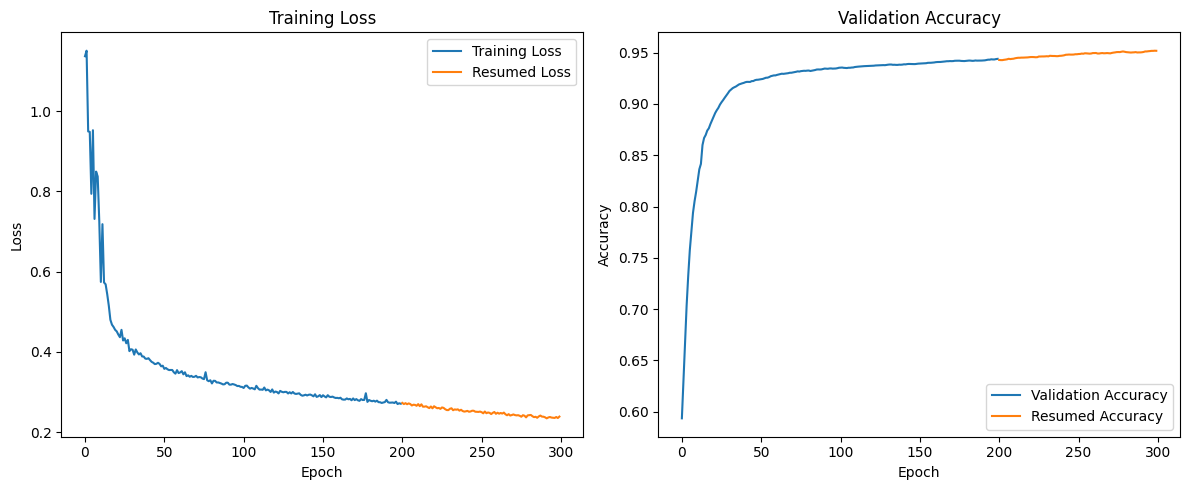

In [41]:
# Cell 8a: Plot training loss and validation accuracy

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Training Loss")
if 'loss_history_resume' in globals():
    plt.plot(range(len(loss_history), len(loss_history) + len(loss_history_resume)), loss_history_resume, label="Resumed Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_history, label="Validation Accuracy")
if 'val_history_resume' in globals():
    plt.plot(range(len(val_history), len(val_history) + len(val_history_resume)), val_history_resume, label="Resumed Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


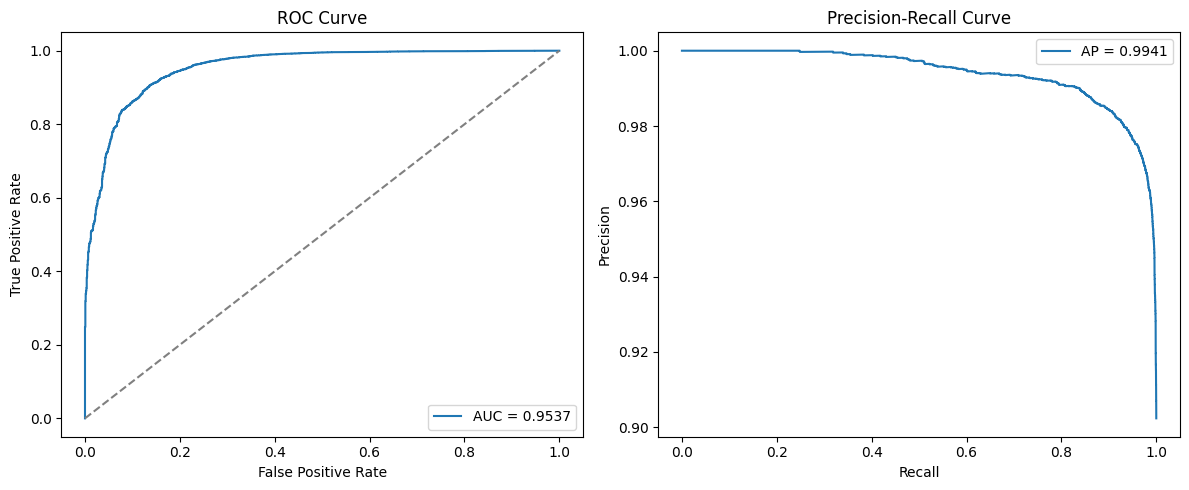

In [42]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# Compute ROC curve and PR curve
fpr, tpr, _ = roc_curve(y_true, probs)
precision, recall, _ = precision_recall_curve(y_true, probs)

# Calculate ROC AUC and PR AUC
roc_auc = roc_auc_score(y_true, probs)
pr_auc = average_precision_score(y_true, probs)

# Plot ROC and PR curves
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()
